3. Feature Engineering Automation 🛠️
Scenario: We need engineered features (rolling means, ratios) for better anomaly detection.

Tasks:

Implement Feature Functions: Write pandas functions to create: 1) 7-day rolling averages of emissions. 2) Emission intensity (emissions / production_volume). 3) Day-of-week/Month features.
Implement Feature Selection: Add a step using sklearn.feature_selection.SelectKBest or RFE to choose the most important features based on a (simulated) target variable.
Validate: Explain how you'd use SHAP to validate the importance of your engineered features after training a simple model (e.g., RandomForestRegressor).
Code Sample (Python pandas - Needs More Features & Selection!):

In [14]:
import pandas as pd

def basic_features(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # PROBLEM: Only basic time features. Needs rolling stats, ratios, etc.
    df['hour'] = df['timestamp'].dt.hour
    return df

# df = pd.DataFrame({'timestamp': pd.to_datetime(['2024-01-01', '2024-01-02']),
#                    'emissions': [100, 110], 'production': [50, 55]})
# TASK: Add rolling mean, intensity, and feature selection steps.
# Our Take: Raw data isn't enough. Show us how you'd engineer insightful
# features and select the best ones.

In [15]:
!pip install shap


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: i assumed data has imestamp, emissions, production_volume as input.
We can adjust later with our real data

In [16]:
import pandas as pd

def engineer_features(df):
    """
    Engineer features for emissions data to enhance anomaly detection.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with 'timestamp', 'emissions', and 'production_volume' columns.
    
    Returns:
    pd.DataFrame: DataFrame with added features: rolling mean, emission intensity, day-of-week, month.
    """
    # Ensure timestamp is in datetime format
    df = df.copy()  # Avoid modifying input
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # 1. 7-day rolling average of emissions
    df['emissions_roll_avg_7d'] = df['emissions'].rolling(window=7, min_periods=1).mean()
    
    # 2. Emission intensity (emissions / production_volume)
    df['emission_intensity'] = df['emissions'] / df['production_volume'].replace(0, 1e-6)  # Avoid division by zero
    
    # 3. Day-of-week and month features
    df['day_of_week'] = df['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['month'] = df['timestamp'].dt.month  # 1=January, 12=December
    
    return df



Explanation:

Rolling Average: Computes a 7-day moving average of emissions to capture weekly trends, using min_periods=1 to handle initial periods.
Emission Intensity: Calculates emissions / production_volume, with a small constant (1e-6) to prevent division by zero.
Time Features: Extracts day_of_week and month from timestamp to capture temporal patterns (e.g., weekly or seasonal effects).
Copy Input: Uses df.copy() to avoid modifying the input DataFrame, ensuring immutability

In [17]:
#Implement feature selection
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

def select_features(df, k=3):
    """
    Select the top k features using SelectKBest based on a simulated target.
    
    Parameters:
    df (pd.DataFrame): DataFrame with engineered features and 'emissions' column.
    k (int): Number of features to select.
    
    Returns:
    pd.DataFrame: DataFrame with selected features.
    list: Names of selected features.
    """
    # Simulate a target variable (e.g., next day's emissions)
    df = df.copy()
    df['target'] = df['emissions'].shift(-1).fillna(method='ffill')
    
    # Feature columns (exclude timestamp, target, and emissions)
    feature_cols = [col for col in df.columns if col not in ['timestamp', 'target', 'emissions']]
    X = df[feature_cols]
    y = df['target']
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply SelectKBest
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X_scaled, y)
    
    # Get selected feature names
    selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]
    
    # Return DataFrame with selected features and other columns
    result_df = df[['timestamp', 'emissions','target'] + selected_features]
    
    return result_df, selected_features


Explanation:

Target Simulation: Uses emissions.shift(-1) as a proxy target to mimic predicting future emissions, relevant for anomaly detection.
Feature Selection: SelectKBest with f_regression selects the top k=3 features based on their correlation with the target.
Standardization: Scales features using StandardScaler to ensure fair comparison, as features like emissions_roll_avg_7d and day_of_week have different scales.
Output: Returns a DataFrame with selected features and the list of feature name

## Steps of the validation with shap

1. **Train the Model**  
   Train a `RandomForestRegressor` on `df_selected` using the selected features to predict the simulated target.

2. **Compute SHAP Values**  
   Use `shap.TreeExplainer` to calculate SHAP values for each feature, quantifying its contribution to individual predictions.

3. **Visualize SHAP Results**  
   - **Summary Plot**: Ranks features by importance and shows impact direction.  
   - **Beeswarm Plot**: Displays how feature values push predictions higher or lower.  

4. **Interpret Results**  
   - **Feature Importance**: Checking that engineered features  rank highly.  
   - **Consistency**: Comparing SHAP rankings with our `SelectKBest` results.
   - **Anomaly Relevance**: Look at SHAP values on known outliers—high values confirm anomaly sensitivity.


In [18]:
import shap
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

def validate_with_shap(df, selected_features):
    """
    Validate feature importance using SHAP on a RandomForestRegressor.
    
    Parameters:
    df (pd.DataFrame): DataFrame with selected features and 'target' column.
    selected_features (list): List of selected feature names.
    
    Returns:
    None: Displays SHAP plots with interpretive comments.
    """
    X = df[selected_features]

    y = df['target']
    
    # Train RandomForestRegressor
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)
    
    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # Summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X, show=False)
    plt.title("SHAP Summary Plot: Feature Importance")
    plt.tight_layout()
    plt.show()
    
    # Beeswarm plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title("SHAP Beeswarm Plot: Feature Impact")
    plt.tight_layout()
    plt.show()


Engineered DataFrame:
     timestamp  emissions  production_volume  emissions_roll_avg_7d  \
0  2024-01-01        100                 50             100.000000   
1  2024-01-02        110                 55             105.000000   
2  2024-01-03        105                 52             105.000000   
3  2024-01-04        120                 60             108.750000   
4  2024-01-05        115                 58             110.000000   
5  2024-01-06        130                 65             113.333333   
6  2024-01-07        125                 62             115.000000   
7  2024-01-08        110                 55             116.428571   
8  2024-01-09        108                 54             116.142857   
9  2024-01-10        115                 57             117.571429   
10 2024-01-11        120                 60             117.571429   
11 2024-01-12        118                 59             118.000000   
12 2024-01-13        122                 61             116.857143 

C:\Users\user\AppData\Local\Temp\ipykernel_10020\3753430478.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['target'] = df['emissions'].shift(-1).fillna(method='ffill')


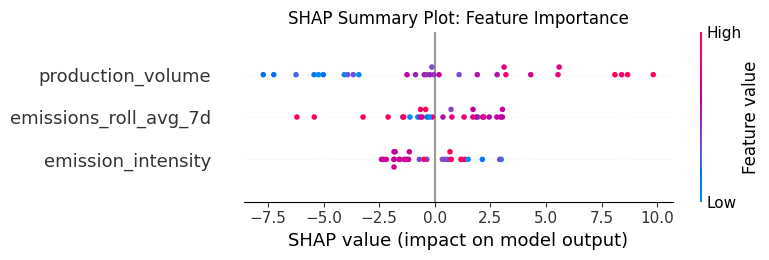

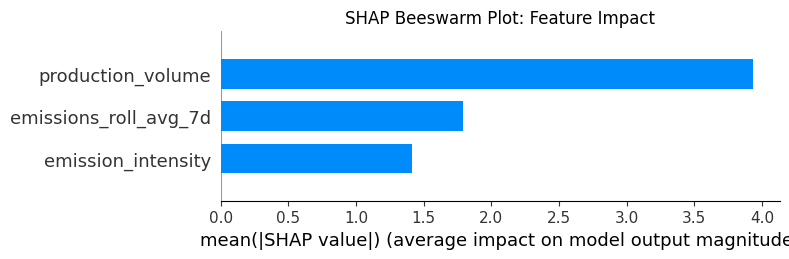

In [19]:
# Simulate example data
data = pd.DataFrame({
    'timestamp': pd.date_range(start='2024-01-01', periods=30, freq='D'),
    'emissions': [100, 110, 105, 120, 115, 130, 125, 110, 108, 115, 
                  120, 118, 122, 126, 130, 135, 128, 112, 109, 116, 
                  121, 119, 123, 127, 131, 136, 129, 113, 111, 117],
    'production_volume': [50, 55, 52, 60, 58, 65, 62, 55, 54, 57, 
                          60, 59, 61, 63, 66, 68, 64, 56, 53, 58, 
                          62, 60, 61, 64, 67, 69, 65, 57, 55, 59]
})

# Apply feature engineering
df_engineered = engineer_features(data)
print("Engineered DataFrame:\n", df_engineered)



# Apply feature selection to engineered DataFrame
df_selected, selected_features = select_features(df_engineered, k=3)
print("Selected Features:", selected_features)
print("DataFrame with Selected Features:\n", df_selected)

# Validate with SHAP
validate_with_shap(df_selected, selected_features)

Explanation:

Model: Uses RandomForestRegressor for compatibility with SHAP’s TreeExplainer, which is efficient for tree-based models.
SHAP Values: Quantify each feature’s contribution to predictions, allowing us to validate whether engineered features are impactful

    The SHAP beeswarm plot shows the average impact of each feature on predictions. Strong contributions from engineered features confirm their relevance for identifying unusual patterns in emissions data.

    The SHAP summary plot ranks features by their contribution to predicting future emissions. High-ranking features like emission_volume or emissions_roll_avg_7d validate their importance for detecting anomalies, such as emission spikes.
    while emission_intensity showed less shap values reflecting less usefullness for anomaly detection:
    Feature Ranking:

    For production_volume, higher feature values (red dots) drive the prediction up (positive SHAP), suggesting that larger production volumes tend to lead to higher next-day emissions.

    For emissions_roll_avg_7d, high rolling averages (red) also push predictions upward, confirming that sustained high emissions signal continued high emissions.

    emission_intensity has mostly low-magnitude impacts around zero, meaning its effect on model output is minimal and sometimes slightly negative when values are high (pink/blue mix around zero).
